## Predizendo número de suicídios a partir de variáveis econômicas

Utilizando a extração de dados que realizamos [aqui](https://github.com/GabrielReisR/suicide_in_brazil/blob/main/data/getting_pysus_data_2010_2019.ipynb), vamos agora tentar predizer número de suicídios a partir de variáveis econômicas. As variáveis escolhidas foram:

- Taxa de inflação (mensal)
- Salário mínimo (mensal)
- Massa salarial ampliada (mensal)
- Estoque de empregos em saúde (mensal)
- Dívida líquida do setor público em milhões (mensal)
- Indicador de tendência de preços de imóveis (mensal)

Taxa de inflação, salário mínimo e massa salarial ampliada estão relacionadas a indicadores econômicos importantes relacionadas à poder de compra e possibilidade de renda. Estoque de empregos em saúde pode estar relacionada à disponibilidade de serviços de saúde para a população. Dívida líquida do setor público é uma variável macroeconômica relacionada às dívidas da União. Enquanto isso, o indicador de tendência de preços de imóveis estão relacionadas ao aumento ou à diminuição dos valores de imóveis no Brasil - o que pode estar relacionado a boas condições de moradia.

A variável desfecho é o número de mortes por suicídio no Brasil (mensal).

### Inicializando

In [1]:
# Standard libraries and plot modules
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as random
import seaborn as sns
%config Completer.use_jedi = False # this speeds up autocomplete

In [3]:
# Preprocessing and data preparation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
from sklearn.model_selection import train_test_split

# Algorithms
## Linear models
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor

## Kernels
from sklearn.kernel_ridge import KernelRidge

## Support Vector Machines
from sklearn.svm import LinearSVR
from sklearn.svm import NuSVR
from sklearn.svm import SVR

## Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

## Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor

## Cross decomposition
from sklearn.cross_decomposition import PLSRegression

## Decision trees
from sklearn.tree import DecisionTreeRegressor

## Ensemble methods
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

## Isotonic regression
from sklearn.isotonic import IsotonicRegression

## Neural network
from sklearn.neural_network import MLPRegressor

# Cross-validation
from sklearn.model_selection import GridSearchCV

# Model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Feature importance
import eli5
from eli5.sklearn import PermutationImportance

In [31]:
import session_info
session_info.show()

In [ ]:
'''
-----
eli5                0.11.0
matplotlib          3.3.2
numpy               1.19.2
pandas              1.1.3
seaborn             0.11.0
session_info        1.0.0
sklearn             0.23.2
-----
Click to view modules imported as dependencies
-----
IPython             7.19.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.2.6
notebook            6.1.4
-----
Python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19041-SP0
-----
Session information updated at 2021-08-16 18:10
'''

### Lendo o banco de dados

In [4]:
df = pd.read_csv('../data/monthly_total.csv', index_col = 0)
df = df.set_index('index') # organizando index
print(df.head())
print(df.tail())

              n
index          
2010-01-01  851
2010-02-01  726
2010-03-01  803
2010-04-01  757
2010-05-01  810
               n
index           
2019-08-01  1107
2019-09-01  1176
2019-10-01  1136
2019-11-01  1152
2019-12-01  1189


### Baixando dados socioeconômicos (de 2010-01-01 até 2019-12-01)

In [5]:
'''
Code from: https://www.youtube.com/watch?v=7rFsu48oBn8&list=PLCAhGm8nJ9CBn51o0x3j1p1LuMRqpeqCy
I added the arguments 'data_inicio' and 'data_final' to help filtering the data.
''' 

# Creating scraping code
def consulta_bc(codigo_bcb, data_inicio = '2010-01-01', data_final = '2019-12-31'):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  df = df[df.index >= data_inicio]
  return df[df.index < data_final]

In [6]:
# Inflação
ipca = consulta_bc(433)

In [7]:
# Salário mínimo
salario_minimo = consulta_bc(1619)

In [8]:
# Massa salarial ampliada
msa = consulta_bc(22078)

In [9]:
# Estoque de empregos em saúde
estoque_empregos_saude = consulta_bc(28782)

In [10]:
# Dívida líquida do setor público em milhões
divida_liquida = consulta_bc(4468)

In [11]:
# Indicador de tendência de preços de imóveis
mvg_r = consulta_bc(25419)

### Juntando os dados

In [12]:
df['ipca'] = ipca['valor']
df['salario_minimo'] = salario_minimo['valor']
df['msa'] = msa['valor']
df['estoque_empregos_saude'] = estoque_empregos_saude['valor']
df['divida_liquida'] = divida_liquida['valor']
df['mvg_r'] = mvg_r['valor']
df

,n,ipca,salario_minimo,msa,estoque_empregos_saude,divida_liquida,mvg_r
index,,,,,,,
2010-01-01,851,0.75,510.0,135781.9,1535523,903896.84,84000
2010-02-01,726,0.78,510.0,135612.4,1543020,926827.67,85000
2010-03-01,803,0.52,510.0,132378.3,1550375,948069.64,87012
2010-04-01,757,0.57,510.0,134216.8,1562963,951442.44,88000
2010-05-01,810,0.43,510.0,135625.4,1573667,948538.76,89070
...,...,...,...,...,...,...,...
2019-08-01,1107,0.11,998.0,298605.9,2342092,2903771.35,183500
2019-09-01,1176,-0.04,998.0,306757.0,2350090,2944328.62,185000
2019-10-01,1136,0.10,998.0,306844.3,2355070,3003316.76,180000


### Explorando associação dos dados

<AxesSubplot:>

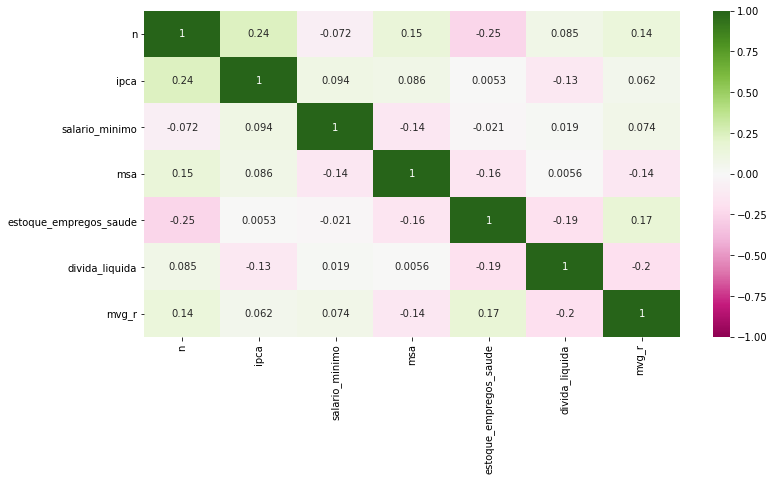

In [13]:
matplotlib.rcParams['figure.figsize'] = (12, 6)

# Creating correlation
corr = df.pct_change().corr('spearman')

# With values
sns.heatmap(corr, 
            vmin = -1, vmax = 1,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            cmap = "PiYG",
            annot = True # this argument must be 'False'
           )

### Preparando função para ML

In [14]:
MLA = [
    
    # Linear models
    ARDRegression(),
    BayesianRidge(),
    ElasticNetCV(),
    HuberRegressor(),
    LassoCV(),
    LassoLars(alpha =.1),
    LinearRegression(),
    MultiTaskLasso(alpha =.1),
    PassiveAggressiveRegressor(),
    Ridge(alpha =.5),
    RidgeCV(),
    SGDRegressor(),
    TheilSenRegressor(),
    RANSACRegressor(min_samples=1),

    # Kernels
    KernelRidge(),
    
    # Support Vector Machines
    LinearSVR(),
    NuSVR(),
    SVR(),
    
    # Nearest Neighbors
    KNeighborsRegressor(),
    
    # Gaussian processes
    GaussianProcessRegressor(),
    
    # Cross decomposition
    PLSRegression(n_components=5),
    
    # Decision trees
    DecisionTreeRegressor(),
    
    # Ensemble methods
    AdaBoostRegressor(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    HistGradientBoostingRegressor(),
    RandomForestRegressor()
]

In [15]:
# Preparing hyperparameters
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

'''
This code was initially built by Dalton Costa (https://www.linkedin.com/in/dalton-breno-costa-33303313a/)
It was initially built to compare several classification algorithms
Gabriel Rodrigues (https://reisrgabriel.com) has made several changes to the 
original code, altering the aim from classification to regression.
However, the structure remains the same as it was originally conceived by Dalton.
'''

def run_ml():
    row_index = 0
    random.seed(42)
    for _ in range(10): # Code will run 10 times

        for alg in MLA:

            # Running ML algorithms
            train = alg.fit(X_train, y_train)
            predicted = train.predict(X_test)

            # Organizing pd.DataFrame 'MLA_compare'
            MLA_name = alg.__class__.__name__

            MLA_compare.loc[row_index,
                            'MLA Name'] = MLA_name

            # Training metrics
            MLA_compare.loc[row_index,
                            'Mean Train Score'] = round(alg.score(X_train, y_train), 4)

            MLA_compare.loc[row_index,
                            'Train MSE'] = round(mean_squared_error(y_train, train.predict(X_train)), 4)
            
            MLA_compare.loc[row_index,
                            'Train R Squared'] = round(r2_score(y_train, train.predict(X_train)), 4)

            MLA_compare.loc[row_index,
                            'Train MAE'] = round(mean_absolute_error(y_train, train.predict(X_train)), 4)
            
            # Test metrics
            MLA_compare.loc[row_index,
                            'Mean Test Score'] = round(alg.score(X_test, y_test), 4)

            MLA_compare.loc[row_index,
                            'Test MSE'] = round(mean_squared_error(y_test, train.predict(X_test)), 4)
            
            MLA_compare.loc[row_index,
                            'Test R Squared'] = round(r2_score(y_test, train.predict(X_test)), 4)

            MLA_compare.loc[row_index,
                            'Test MAE'] = round(mean_absolute_error(y_test, train.predict(X_test)), 4)

            
            #print(row_index)
            #print(MLA_compare['MLA Name'])

            # Training
            #print(MLA_compare['Mean Train Score'])
            #print(MLA_compare['Train MSE'])
            #print(MLA_compare['Train R Squared'])
            #print(MLA_compare['Train MAE'])

            # Test
            #print(MLA_compare['Mean Test Score'])
            #print(MLA_compare['Test MSE'])
            #print(MLA_compare['Test R Squared'])
            #print(MLA_compare['Test MAE'])

            row_index+=1

In [16]:
# Selecting X features and dependent variable Y
X = df.drop(columns = 'n')
y = df[['n']]

# Creating X and y train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 42)


# Normalizing features in X_train and X_test
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

<ipython-input-16-70c46fba194d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
C:\Users\reisr\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-16-70c46fba194d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

### Rodando ML

In [17]:
run_ml()

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0
0    ARDRegression
Name: MLA Name, dtype: object
0    0.8274
Name: Mean Train Score, dtype: float64
0    2704.6783
Name: Train MSE, dtype: float64
0    0.8274
Name: Train R Squared, dtype: float64
0    39.9507
Name: Train MAE, dtype: float64
0    0.7408
Name: Mean Test Score, dtype: float64
0    2151.4021
Name: Test MSE, dtype: float64
0    0.7408
Name: Test R Squared, dtype: float64
0    34.9024
Name: Test MAE, dtype: float64
1
0    ARDRegression
1    BayesianRidge
Name: MLA Name, dtype: object
0    0.8274
1    0.8279
Name: Mean Train Score, dtype: float64
0    2704.6783
1    2697.5486
Name: Train MSE, dtype: float64
0    0.8274
1    0.8279
Name: Train R Squared, dtype: float64
0    39.9507
1    39.8776
Name: Train MAE, dtype: float64
0    0.7408
1    0.7489
Name: Mean Test Score, dtype: float64
0    2151.4021
1    2083.9411
Name: Test MSE, dtype: float64
0    0.7408
1    0.7489
Name: Test R Squared, dtype: float64
0    34.9024
1    33.9027
Name: Test MAE, dtype: float64
2
0    ARDR

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0    2704.6783
1    2697.5486
2    2988.3242
3    2654.3826
4    2644.6784
Name: Train MSE, dtype: float64
0    0.8274
1    0.8279
2    0.8093
3    0.8306
4    0.8313
Name: Train R Squared, dtype: float64
0    39.9507
1    39.8776
2    42.6465
3    39.5138
4    39.5249
Name: Train MAE, dtype: float64
0    0.7408
1    0.7489
2    0.7293
3    0.7573
4    0.7549
Name: Mean Test Score, dtype: float64
0    2151.4021
1    2083.9411
2    2246.8709
3    2014.7913
4    2034.6964
Name: Test MSE, dtype: float64
0    0.7408
1    0.7489
2    0.7293
3    0.7573
4    0.7549
Name: Test R Squared, dtype: float64
0    34.9024
1    33.9027
2    36.4276
3    33.8136
4    33.2617
Name: Test MAE, dtype: float64
5
0     ARDRegression
1     BayesianRidge
2      ElasticNetCV
3    HuberRegressor
4           LassoCV
5         LassoLars
Name: MLA Name, dtype: object
0    0.8274
1    0.8279
2    0.8093
3    0.8306
4    0.8313
5    0.8210
Name: Mean Train Score, dtype: float64
0    2704.6783
1    2697.5486
2    29

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


10
0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
5                      LassoLars
6               LinearRegression
7                 MultiTaskLasso
8     PassiveAggressiveRegressor
9                          Ridge
10                       RidgeCV
Name: MLA Name, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
5     0.8210
6     0.8315
7     0.8313
8     0.8175
9     0.8302
10    0.8282
Name: Mean Train Score, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
5     2805.2350
6     2641.1850
7     2644.0683
8     2860.2105
9     2660.6648
10    2692.3048
Name: Train MSE, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
5     0.8210
6     0.8315
7     0.8313
8     0.8175
9     0.8302
10    0.8282
Name: Train R Squared, dtype: float64
0     39.9507
1     39.8776
2    

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


12
0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
5                      LassoLars
6               LinearRegression
7                 MultiTaskLasso
8     PassiveAggressiveRegressor
9                          Ridge
10                       RidgeCV
11                  SGDRegressor
12             TheilSenRegressor
Name: MLA Name, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
5     0.8210
6     0.8315
7     0.8313
8     0.8175
9     0.8302
10    0.8282
11    0.8251
12    0.8243
Name: Mean Train Score, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
5     2805.2350
6     2641.1850
7     2644.0683
8     2860.2105
9     2660.6648
10    2692.3048
11    2741.6982
12    2753.7509
Name: Train MSE, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
5     0.8210
6     0.8315

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


15
0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
5                      LassoLars
6               LinearRegression
7                 MultiTaskLasso
8     PassiveAggressiveRegressor
9                          Ridge
10                       RidgeCV
11                  SGDRegressor
12             TheilSenRegressor
13               RANSACRegressor
14                   KernelRidge
15                     LinearSVR
Name: MLA Name, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
5      0.8210
6      0.8315
7      0.8313
8      0.8175
9      0.8302
10     0.8282
11     0.8251
12     0.8243
13     0.4695
14   -55.6202
15   -45.5140
Name: Mean Train Score, dtype: float64
0       2704.6783
1       2697.5486
2       2988.3242
3       2654.3826
4       2644.6784
5       2805.2350
6       2641.1850
7       2644.0683
8       2860.2105
9       2660.6

19
0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
5                      LassoLars
6               LinearRegression
7                 MultiTaskLasso
8     PassiveAggressiveRegressor
9                          Ridge
10                       RidgeCV
11                  SGDRegressor
12             TheilSenRegressor
13               RANSACRegressor
14                   KernelRidge
15                     LinearSVR
16                         NuSVR
17                           SVR
18           KNeighborsRegressor
19      GaussianProcessRegressor
Name: MLA Name, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
5      0.8210
6      0.8315
7      0.8313
8      0.8175
9      0.8302
10     0.8282
11     0.8251
12     0.8243
13     0.4695
14   -55.6202
15   -45.5140
16     0.1447
17     0.1653
18     0.8530
19     1.0000
Name: Mean Train Score, dty

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


22
0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
5                      LassoLars
6               LinearRegression
7                 MultiTaskLasso
8     PassiveAggressiveRegressor
9                          Ridge
10                       RidgeCV
11                  SGDRegressor
12             TheilSenRegressor
13               RANSACRegressor
14                   KernelRidge
15                     LinearSVR
16                         NuSVR
17                           SVR
18           KNeighborsRegressor
19      GaussianProcessRegressor
20                 PLSRegression
21         DecisionTreeRegressor
22             AdaBoostRegressor
Name: MLA Name, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
5      0.8210
6      0.8315
7      0.8313
8      0.8175
9      0.8302
10     0.8282
11     0.8251
12     0.8243
13     0.4695
14   -55.620

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


24
0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
5                      LassoLars
6               LinearRegression
7                 MultiTaskLasso
8     PassiveAggressiveRegressor
9                          Ridge
10                       RidgeCV
11                  SGDRegressor
12             TheilSenRegressor
13               RANSACRegressor
14                   KernelRidge
15                     LinearSVR
16                         NuSVR
17                           SVR
18           KNeighborsRegressor
19      GaussianProcessRegressor
20                 PLSRegression
21         DecisionTreeRegressor
22             AdaBoostRegressor
23              BaggingRegressor
24           ExtraTreesRegressor
Name: MLA Name, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
5      0.8210
6      0.8315
7      0.8313
8      0.8175
9      0.8302
10

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


26
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
Name: MLA Name, dtype: ob

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


27
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


30
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


32
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

Name: Mean Test Score, dtype: float64
0       2151.4021
1       2083.9411
2       2246.8709
3       2014.7913
4       2034.6964
5       2211.5109
6       2014.5190
7       2032.6132
8       2360.9909
9       2045.6215
10      2078.8262
11      2153.0886
12      1893.8865
13      3057.3405
14    856911.6504
15    695058.2917
16      7150.9359
17      6208.1590
18      2966.6517
19     76464.8223
20      2048.9239
21      5838.0417
22      3513.5832
23      2715.1400
24      4164.1980
25      3569.8173
26      3706.9858
27      3223.2624
28      2151.4021
29      2083.9411
30      2246.8709
31      2014.7913
32      2034.6964
33      2211.5109
34      2014.5190
Name: Test MSE, dtype: float64
0       0.7408
1       0.7489
2       0.7293
3       0.7573
4       0.7549
5       0.7336
6       0.7573
7       0.7551
8       0.7156
9       0.7536
10      0.7496
11      0.7406
12      0.7718
13      0.6317
14   -102.2325
15    -82.7340
16      0.1385
17      0.2521
18      0.6426
19     -8.2118
2

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
5      0.8210
6      0.8315
7      0.8313
8      0.8175
9      0.8302
10     0.8282
11     0.8251
12     0.8243
13     0.4695
14   -55.6202
15   -45.5140
16     0.1447
17     0.1653
18     0.8530
19     1.0000
20     0.8313
21     1.0000
22     0.9176
23     0.9535
24     1.0000
25     0.9896
26     0.8922
27     0.9682
28     0.8274
29     0.8279
30     0.8093
31     0.8306
32     0.8313
33     0.8210
34     0.8315
35     0.8313
36     0.8236
37     0.8302
Name: Mean Train Score, dtype: float64
0       2704.6783
1       2697.5486
2       2988.3242
3       2654.3826
4       2644.6784
5       2805.2350
6       2641.1850
7       2644.0683
8       2860.2105
9       2660.6648
10      2692.3048
11      2741.6982
12      2753.7509
13      8314.6815
14    887428.5031
15    729029.5417
16     13404.8192
17     13082.6073
18      2304.7075
19         0.0000
20      2644.5219
21         0.0000
22      1291.6018
23       728.5

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


40
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


43
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

46
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

49
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


50
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


52
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


54
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


55
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
5                         LassoLars
6                  LinearRegression
7                    MultiTaskLasso
8        PassiveAggressiveRegressor
9                             Ridge
10                          RidgeCV
11                     SGDRegressor
12                TheilSenRegressor
13                  RANSACRegressor
14                      KernelRidge
15                        LinearSVR
16                            NuSVR
17                              SVR
18              KNeighborsRegressor
19         GaussianProcessRegressor
20                    PLSRegression
21            DecisionTreeRegressor
22                AdaBoostRegressor
23                 BaggingRegressor
24              ExtraTreesRegressor
25        GradientBoostingRegressor
26    HistGradientBoostingRegressor
27            RandomFores

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0       0.7408
1       0.7489
2       0.7293
3       0.7573
4       0.7549
5       0.7336
6       0.7573
7       0.7551
8       0.7156
9       0.7536
10      0.7496
11      0.7406
12      0.7718
13      0.6317
14   -102.2325
15    -82.7340
16      0.1385
17      0.2521
18      0.6426
19     -8.2118
20      0.7532
21      0.2967
22      0.5767
23      0.6729
24      0.4983
25      0.5699
26      0.5534
27      0.6117
28      0.7408
29      0.7489
30      0.7293
31      0.7573
32      0.7549
33      0.7336
34      0.7573
35      0.7551
36      0.7446
37      0.7536
38      0.7496
39      0.7446
40      0.7675
41      0.6406
42   -102.2325
43    -82.7340
44      0.1385
45      0.2521
46      0.6426
47     -8.2118
48      0.7532
49      0.1901
50      0.5604
51      0.6184
52      0.5596
53      0.5739
54      0.5534
55      0.6276
56      0.7408
57      0.7489
Name: Test R Squared, dtype: float64
0      34.9024
1      33.9027
2      36.4276
3      33.8136
4      33.2617
5      35.8107
6 

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


60
0      ARDRegression
1      BayesianRidge
2       ElasticNetCV
3     HuberRegressor
4            LassoCV
           ...      
56     ARDRegression
57     BayesianRidge
58      ElasticNetCV
59    HuberRegressor
60           LassoCV
Name: MLA Name, Length: 61, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
56    0.8274
57    0.8279
58    0.8093
59    0.8306
60    0.8313
Name: Mean Train Score, Length: 61, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
56    2704.6783
57    2697.5486
58    2988.3242
59    2654.3826
60    2644.6784
Name: Train MSE, Length: 61, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
56    0.8274
57    0.8279
58    0.8093
59    0.8306
60    0.8313
Name: Train R Squared, Length: 61, dtype: float64
0     39.9507
1     39.8776
2     42.6465
3     39.5138
4     39.5249
       ...   
56    39.9507
57    39.8776
58   

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
                 ...            
62              LinearRegression
63                MultiTaskLasso
64    PassiveAggressiveRegressor
65                         Ridge
66                       RidgeCV
Name: MLA Name, Length: 67, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
62    0.8315
63    0.8313
64    0.8211
65    0.8302
66    0.8282
Name: Mean Train Score, Length: 67, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
62    2641.1850
63    2644.0683
64    2803.5135
65    2660.6648
66    2692.3048
Name: Train MSE, Length: 67, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
62    0.8315
63    0.8313
64    0.8211
65    0.8302
66    0.8282
Name: Train R Squared, Length: 67, dt

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


68
0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
                 ...            
64    PassiveAggressiveRegressor
65                         Ridge
66                       RidgeCV
67                  SGDRegressor
68             TheilSenRegressor
Name: MLA Name, Length: 69, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
64    0.8211
65    0.8302
66    0.8282
67    0.8251
68    0.8241
Name: Mean Train Score, Length: 69, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
64    2803.5135
65    2660.6648
66    2692.3048
67    2740.5360
68    2756.5942
Name: Train MSE, Length: 69, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
64    0.8211
65    0.8302
66    0.8282
67    0.8251
68    0.8241
Name: Train R Squared, Length: 69, 

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


71
0         ARDRegression
1         BayesianRidge
2          ElasticNetCV
3        HuberRegressor
4               LassoCV
            ...        
67         SGDRegressor
68    TheilSenRegressor
69      RANSACRegressor
70          KernelRidge
71            LinearSVR
Name: MLA Name, Length: 72, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
       ...   
67     0.8251
68     0.8241
69     0.5289
70   -55.6202
71   -45.5140
Name: Mean Train Score, Length: 72, dtype: float64
0       2704.6783
1       2697.5486
2       2988.3242
3       2654.3826
4       2644.6784
         ...     
67      2740.5360
68      2756.5942
69      7382.9341
70    887428.5031
71    729029.5417
Name: Train MSE, Length: 72, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
       ...   
67     0.8251
68     0.8241
69     0.5289
70   -55.6202
71   -45.5140
Name: Train R Squared, Length: 72, dtype: float64
0      39.9507
1      39.8776
2      42.

0                ARDRegression
1                BayesianRidge
2                 ElasticNetCV
3               HuberRegressor
4                      LassoCV
                ...           
72                       NuSVR
73                         SVR
74         KNeighborsRegressor
75    GaussianProcessRegressor
76               PLSRegression
Name: MLA Name, Length: 77, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
72    0.1447
73    0.1653
74    0.8530
75    1.0000
76    0.8313
Name: Mean Train Score, Length: 77, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
72    13404.8192
73    13082.6073
74     2304.7075
75        0.0000
76     2644.5219
Name: Train MSE, Length: 77, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
72    0.1447
73    0.1653
74    0.8530
75    1.0000
76    0.8313
Name: Train R Squared, Length: 77, dtype: float64

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


78
0                ARDRegression
1                BayesianRidge
2                 ElasticNetCV
3               HuberRegressor
4                      LassoCV
                ...           
74         KNeighborsRegressor
75    GaussianProcessRegressor
76               PLSRegression
77       DecisionTreeRegressor
78           AdaBoostRegressor
Name: MLA Name, Length: 79, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
74    0.8530
75    1.0000
76    0.8313
77    1.0000
78    0.9270
Name: Mean Train Score, Length: 79, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
74    2304.7075
75       0.0000
76    2644.5219
77       0.0000
78    1143.6401
Name: Train MSE, Length: 79, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
74    0.8530
75    1.0000
76    0.8313
77    1.0000
78    0.9270
Name: Train R Squared, Length: 79, dtype: float64
0     3

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


80
0             ARDRegression
1             BayesianRidge
2              ElasticNetCV
3            HuberRegressor
4                   LassoCV
              ...          
76            PLSRegression
77    DecisionTreeRegressor
78        AdaBoostRegressor
79         BaggingRegressor
80      ExtraTreesRegressor
Name: MLA Name, Length: 81, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
76    0.8313
77    1.0000
78    0.9270
79    0.9569
80    1.0000
Name: Mean Train Score, Length: 81, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
76    2644.5219
77       0.0000
78    1143.6401
79     675.9752
80       0.0012
Name: Train MSE, Length: 81, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
76    0.8313
77    1.0000
78    0.9270
79    0.9569
80    1.0000
Name: Train R Squared, Length: 81, dtype: float64
0     39.9507
1     39.8776
2     42.646

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


82
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
                  ...              
78                AdaBoostRegressor
79                 BaggingRegressor
80              ExtraTreesRegressor
81        GradientBoostingRegressor
82    HistGradientBoostingRegressor
Name: MLA Name, Length: 83, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
78    0.9270
79    0.9569
80    1.0000
81    0.9896
82    0.8922
Name: Mean Train Score, Length: 83, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
78    1143.6401
79     675.9752
80       0.0012
81     163.2954
82    1689.1748
Name: Train MSE, Length: 83, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
78    0.9270
79    0.9569
80    1.0000
81    0.9896
82    0.8922
Na

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


83
0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
                  ...              
79                 BaggingRegressor
80              ExtraTreesRegressor
81        GradientBoostingRegressor
82    HistGradientBoostingRegressor
83            RandomForestRegressor
Name: MLA Name, Length: 84, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
79    0.9569
80    1.0000
81    0.9896
82    0.8922
83    0.9684
Name: Mean Train Score, Length: 84, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
79     675.9752
80       0.0012
81     163.2954
82    1689.1748
83     495.6190
Name: Train MSE, Length: 84, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
79    0.9569
80    1.0000
81    0.9896
82    0.8922
83    0.9684
Na

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0                     ARDRegression
1                     BayesianRidge
2                      ElasticNetCV
3                    HuberRegressor
4                           LassoCV
                  ...              
81        GradientBoostingRegressor
82    HistGradientBoostingRegressor
83            RandomForestRegressor
84                    ARDRegression
85                    BayesianRidge
Name: MLA Name, Length: 86, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
81    0.9896
82    0.8922
83    0.9684
84    0.8274
85    0.8279
Name: Mean Train Score, Length: 86, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
81     163.2954
82    1689.1748
83     495.6190
84    2704.6783
85    2697.5486
Name: Train MSE, Length: 86, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
81    0.9896
82    0.8922
83    0.9684
84    0.8274
85    0.8279
Name

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


88
0      ARDRegression
1      BayesianRidge
2       ElasticNetCV
3     HuberRegressor
4            LassoCV
           ...      
84     ARDRegression
85     BayesianRidge
86      ElasticNetCV
87    HuberRegressor
88           LassoCV
Name: MLA Name, Length: 89, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
84    0.8274
85    0.8279
86    0.8093
87    0.8306
88    0.8313
Name: Mean Train Score, Length: 89, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
84    2704.6783
85    2697.5486
86    2988.3242
87    2654.3826
88    2644.6784
Name: Train MSE, Length: 89, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
84    0.8274
85    0.8279
86    0.8093
87    0.8306
88    0.8313
Name: Train R Squared, Length: 89, dtype: float64
0     39.9507
1     39.8776
2     42.6465
3     39.5138
4     39.5249
       ...   
84    39.9507
85    39.8776
86   

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
                 ...            
90              LinearRegression
91                MultiTaskLasso
92    PassiveAggressiveRegressor
93                         Ridge
94                       RidgeCV
Name: MLA Name, Length: 95, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
90    0.8315
91    0.8313
92    0.8209
93    0.8302
94    0.8282
Name: Mean Train Score, Length: 95, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
90    2641.1850
91    2644.0683
92    2806.5122
93    2660.6648
94    2692.3048
Name: Train MSE, Length: 95, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
90    0.8315
91    0.8313
92    0.8209
93    0.8302
94    0.8282
Name: Train R Squared, Length: 95, dt

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


96
0                  ARDRegression
1                  BayesianRidge
2                   ElasticNetCV
3                 HuberRegressor
4                        LassoCV
                 ...            
92    PassiveAggressiveRegressor
93                         Ridge
94                       RidgeCV
95                  SGDRegressor
96             TheilSenRegressor
Name: MLA Name, Length: 97, dtype: object
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
92    0.8209
93    0.8302
94    0.8282
95    0.8238
96    0.8215
Name: Mean Train Score, Length: 97, dtype: float64
0     2704.6783
1     2697.5486
2     2988.3242
3     2654.3826
4     2644.6784
        ...    
92    2806.5122
93    2660.6648
94    2692.3048
95    2761.7392
96    2797.9354
Name: Train MSE, Length: 97, dtype: float64
0     0.8274
1     0.8279
2     0.8093
3     0.8306
4     0.8313
       ...  
92    0.8209
93    0.8302
94    0.8282
95    0.8238
96    0.8215
Name: Train R Squared, Length: 97, 

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


101
0        ARDRegression
1        BayesianRidge
2         ElasticNetCV
3       HuberRegressor
4              LassoCV
            ...       
97     RANSACRegressor
98         KernelRidge
99           LinearSVR
100              NuSVR
101                SVR
Name: MLA Name, Length: 102, dtype: object
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
97      0.4731
98    -55.6202
99    -45.5140
100     0.1447
101     0.1653
Name: Mean Train Score, Length: 102, dtype: float64
0        2704.6783
1        2697.5486
2        2988.3242
3        2654.3826
4        2644.6784
          ...     
97       8258.4358
98     887428.5031
99     729029.5417
100     13404.8192
101     13082.6073
Name: Train MSE, Length: 102, dtype: float64
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
97      0.4731
98    -55.6202
99    -45.5140
100     0.1447
101     0.1653
Name: Train R Squared, Length: 102, dtype: float64
0       39.95

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


106
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
102         KNeighborsRegressor
103    GaussianProcessRegressor
104               PLSRegression
105       DecisionTreeRegressor
106           AdaBoostRegressor
Name: MLA Name, Length: 107, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
102    0.8530
103    1.0000
104    0.8313
105    1.0000
106    0.9243
Name: Mean Train Score, Length: 107, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
102    2304.7075
103       0.0000
104    2644.5219
105       0.0000
106    1185.8546
Name: Train MSE, Length: 107, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
102    0.8530
103    1.0000
104    0.8313
105    1.0000
106    0.9243
Name: Tra

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


108
0              ARDRegression
1              BayesianRidge
2               ElasticNetCV
3             HuberRegressor
4                    LassoCV
               ...          
104            PLSRegression
105    DecisionTreeRegressor
106        AdaBoostRegressor
107         BaggingRegressor
108      ExtraTreesRegressor
Name: MLA Name, Length: 109, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
104    0.8313
105    1.0000
106    0.9243
107    0.9652
108    1.0000
Name: Mean Train Score, Length: 109, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
104    2644.5219
105       0.0000
106    1185.8546
107     545.7567
108       0.0001
Name: Train MSE, Length: 109, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
104    0.8313
105    1.0000
106    0.9243
107    0.9652
108    1.0000
Name: Train R Squared, Length: 109, dtype:

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


110
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
106                AdaBoostRegressor
107                 BaggingRegressor
108              ExtraTreesRegressor
109        GradientBoostingRegressor
110    HistGradientBoostingRegressor
Name: MLA Name, Length: 111, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
106    0.9243
107    0.9652
108    1.0000
109    0.9896
110    0.8922
Name: Mean Train Score, Length: 111, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
106    1185.8546
107     545.7567
108       0.0001
109     163.2954
110    1689.1748
Name: Train MSE, Length: 111, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
106    0.9243
107    0.9

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


111
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
107                 BaggingRegressor
108              ExtraTreesRegressor
109        GradientBoostingRegressor
110    HistGradientBoostingRegressor
111            RandomForestRegressor
Name: MLA Name, Length: 112, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
107    0.9652
108    1.0000
109    0.9896
110    0.8922
111    0.9686
Name: Mean Train Score, Length: 112, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
107     545.7567
108       0.0001
109     163.2954
110    1689.1748
111     492.6172
Name: Train MSE, Length: 112, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
107    0.9652
108    1.0

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
109    0.9896
110    0.8922
111    0.9686
112    0.8274
113    0.8279
Name: Mean Train Score, Length: 114, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
109     163.2954
110    1689.1748
111     492.6172
112    2704.6783
113    2697.5486
Name: Train MSE, Length: 114, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
109    0.9896
110    0.8922
111    0.9686
112    0.8274
113    0.8279
Name: Train R Squared, Length: 114, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      39.5249
        ...   
109    10.3798
110    32.4643
111    16.9955
112    39.9507
113    39.8776
Name: Train MAE, Length: 114, dtype: float64
0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
109    0.6021
110    0.5534
111    0.6149
112    0.7408
113   

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


115
0              ARDRegression
1              BayesianRidge
2               ElasticNetCV
3             HuberRegressor
4                    LassoCV
               ...          
111    RandomForestRegressor
112            ARDRegression
113            BayesianRidge
114             ElasticNetCV
115           HuberRegressor
Name: MLA Name, Length: 116, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
111    0.9686
112    0.8274
113    0.8279
114    0.8093
115    0.8306
Name: Mean Train Score, Length: 116, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
111     492.6172
112    2704.6783
113    2697.5486
114    2988.3242
115    2654.3826
Name: Train MSE, Length: 116, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
111    0.9686
112    0.8274
113    0.8279
114    0.8093
115    0.8306
Name: Train R Squared, Length: 116, dtype:

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
116                       LassoCV
117                     LassoLars
118              LinearRegression
119                MultiTaskLasso
120    PassiveAggressiveRegressor
Name: MLA Name, Length: 121, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
116    0.8313
117    0.8210
118    0.8315
119    0.8313
120    0.8056
Name: Mean Train Score, Length: 121, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
116    2644.6784
117    2805.2350
118    2641.1850
119    2644.0683
120    3047.2835
Name: Train MSE, Length: 121, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
116    0.8313
117    0.8210
118    0.8315
119    0.8313
120 

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


124
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
120    PassiveAggressiveRegressor
121                         Ridge
122                       RidgeCV
123                  SGDRegressor
124             TheilSenRegressor
Name: MLA Name, Length: 125, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
120    0.8056
121    0.8302
122    0.8282
123    0.8198
124    0.8218
Name: Mean Train Score, Length: 125, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
120    3047.2835
121    2660.6648
122    2692.3048
123    2824.4144
124    2793.3618
Name: Train MSE, Length: 125, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
120    0.8056
121    0.8302
122    0.8282
123    0.8198
1

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


127
0          ARDRegression
1          BayesianRidge
2           ElasticNetCV
3         HuberRegressor
4                LassoCV
             ...        
123         SGDRegressor
124    TheilSenRegressor
125      RANSACRegressor
126          KernelRidge
127            LinearSVR
Name: MLA Name, Length: 128, dtype: object
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
123     0.8198
124     0.8218
125     0.4731
126   -55.6202
127   -45.5140
Name: Mean Train Score, Length: 128, dtype: float64
0        2704.6783
1        2697.5486
2        2988.3242
3        2654.3826
4        2644.6784
          ...     
123      2824.4144
124      2793.3618
125      8258.4358
126    887428.5031
127    729029.5417
Name: Train MSE, Length: 128, dtype: float64
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
123     0.8198
124     0.8218
125     0.4731
126   -55.6202
127   -45.5140
Name: Train R Squared, Length: 128, dtype:

133
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
129                         SVR
130         KNeighborsRegressor
131    GaussianProcessRegressor
132               PLSRegression
133       DecisionTreeRegressor
Name: MLA Name, Length: 134, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
129    0.1653
130    0.8530
131    1.0000
132    0.8313
133    1.0000
Name: Mean Train Score, Length: 134, dtype: float64
0       2704.6783
1       2697.5486
2       2988.3242
3       2654.3826
4       2644.6784
          ...    
129    13082.6073
130     2304.7075
131        0.0000
132     2644.5219
133        0.0000
Name: Train MSE, Length: 134, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
129    0.1653
130    0.8530
131    1.0000
132    0.8313
133    1.000

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


135
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
131    GaussianProcessRegressor
132               PLSRegression
133       DecisionTreeRegressor
134           AdaBoostRegressor
135            BaggingRegressor
Name: MLA Name, Length: 136, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
131    1.0000
132    0.8313
133    1.0000
134    0.9237
135    0.9629
Name: Mean Train Score, Length: 136, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
131       0.0000
132    2644.5219
133       0.0000
134    1195.4195
135     581.0236
Name: Train MSE, Length: 136, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
131    1.0000
132    0.8313
133    1.0000
134    0.9237
135    0.9629
Name: Tra

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


136
0              ARDRegression
1              BayesianRidge
2               ElasticNetCV
3             HuberRegressor
4                    LassoCV
               ...          
132            PLSRegression
133    DecisionTreeRegressor
134        AdaBoostRegressor
135         BaggingRegressor
136      ExtraTreesRegressor
Name: MLA Name, Length: 137, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
132    0.8313
133    1.0000
134    0.9237
135    0.9629
136    1.0000
Name: Mean Train Score, Length: 137, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
132    2644.5219
133       0.0000
134    1195.4195
135     581.0236
136       0.0000
Name: Train MSE, Length: 137, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
132    0.8313
133    1.0000
134    0.9237
135    0.9629
136    1.0000
Name: Train R Squared, Length: 137, dtype:

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


138
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
134                AdaBoostRegressor
135                 BaggingRegressor
136              ExtraTreesRegressor
137        GradientBoostingRegressor
138    HistGradientBoostingRegressor
Name: MLA Name, Length: 139, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
134    0.9237
135    0.9629
136    1.0000
137    0.9896
138    0.8922
Name: Mean Train Score, Length: 139, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
134    1195.4195
135     581.0236
136       0.0000
137     163.2954
138    1689.1748
Name: Train MSE, Length: 139, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
134    0.9237
135    0.9

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


139
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
135                 BaggingRegressor
136              ExtraTreesRegressor
137        GradientBoostingRegressor
138    HistGradientBoostingRegressor
139            RandomForestRegressor
Name: MLA Name, Length: 140, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
135    0.9629
136    1.0000
137    0.9896
138    0.8922
139    0.9647
Name: Mean Train Score, Length: 140, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
135     581.0236
136       0.0000
137     163.2954
138    1689.1748
139     553.2764
Name: Train MSE, Length: 140, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
135    0.9629
136    1.0

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


142
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
138    HistGradientBoostingRegressor
139            RandomForestRegressor
140                    ARDRegression
141                    BayesianRidge
142                     ElasticNetCV
Name: MLA Name, Length: 143, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
138    0.8922
139    0.9647
140    0.8274
141    0.8279
142    0.8093
Name: Mean Train Score, Length: 143, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
138    1689.1748
139     553.2764
140    2704.6783
141    2697.5486
142    2988.3242
Name: Train MSE, Length: 143, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
138    0.8922
139    0.9

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


144
0       ARDRegression
1       BayesianRidge
2        ElasticNetCV
3      HuberRegressor
4             LassoCV
            ...      
140     ARDRegression
141     BayesianRidge
142      ElasticNetCV
143    HuberRegressor
144           LassoCV
Name: MLA Name, Length: 145, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
140    0.8274
141    0.8279
142    0.8093
143    0.8306
144    0.8313
Name: Mean Train Score, Length: 145, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
140    2704.6783
141    2697.5486
142    2988.3242
143    2654.3826
144    2644.6784
Name: Train MSE, Length: 145, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
140    0.8274
141    0.8279
142    0.8093
143    0.8306
144    0.8313
Name: Train R Squared, Length: 145, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      3

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
146              LinearRegression
147                MultiTaskLasso
148    PassiveAggressiveRegressor
149                         Ridge
150                       RidgeCV
Name: MLA Name, Length: 151, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
146    0.8315
147    0.8313
148    0.8242
149    0.8302
150    0.8282
Name: Mean Train Score, Length: 151, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
146    2641.1850
147    2644.0683
148    2755.4985
149    2660.6648
150    2692.3048
Name: Train MSE, Length: 151, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
146    0.8315
147    0.8313
148    0.8242
149    0.8302
150 

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


152
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
148    PassiveAggressiveRegressor
149                         Ridge
150                       RidgeCV
151                  SGDRegressor
152             TheilSenRegressor
Name: MLA Name, Length: 153, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
148    0.8242
149    0.8302
150    0.8282
151    0.8269
152    0.8243
Name: Mean Train Score, Length: 153, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
148    2755.4985
149    2660.6648
150    2692.3048
151    2712.4859
152    2753.4313
Name: Train MSE, Length: 153, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
148    0.8242
149    0.8302
150    0.8282
151    0.8269
1

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0          ARDRegression
1          BayesianRidge
2           ElasticNetCV
3         HuberRegressor
4                LassoCV
             ...        
151         SGDRegressor
152    TheilSenRegressor
153      RANSACRegressor
154          KernelRidge
155            LinearSVR
Name: MLA Name, Length: 156, dtype: object
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
151     0.8269
152     0.8243
153     0.4911
154   -55.6202
155   -45.5140
Name: Mean Train Score, Length: 156, dtype: float64
0        2704.6783
1        2697.5486
2        2988.3242
3        2654.3826
4        2644.6784
          ...     
151      2712.4859
152      2753.4313
153      7976.5948
154    887428.5031
155    729029.5417
Name: Train MSE, Length: 156, dtype: float64
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
151     0.8269
152     0.8243
153     0.4911
154   -55.6202
155   -45.5140
Name: Train R Squared, Length: 156, dtype: fl

Name: Test MAE, Length: 161, dtype: float64
161
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
157                         SVR
158         KNeighborsRegressor
159    GaussianProcessRegressor
160               PLSRegression
161       DecisionTreeRegressor
Name: MLA Name, Length: 162, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
157    0.1653
158    0.8530
159    1.0000
160    0.8313
161    1.0000
Name: Mean Train Score, Length: 162, dtype: float64
0       2704.6783
1       2697.5486
2       2988.3242
3       2654.3826
4       2644.6784
          ...    
157    13082.6073
158     2304.7075
159        0.0000
160     2644.5219
161        0.0000
Name: Train MSE, Length: 162, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
157    0.1653
158    0.8

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


162
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
158         KNeighborsRegressor
159    GaussianProcessRegressor
160               PLSRegression
161       DecisionTreeRegressor
162           AdaBoostRegressor
Name: MLA Name, Length: 163, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
158    0.8530
159    1.0000
160    0.8313
161    1.0000
162    0.9197
Name: Mean Train Score, Length: 163, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
158    2304.7075
159       0.0000
160    2644.5219
161       0.0000
162    1258.9302
Name: Train MSE, Length: 163, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
158    0.8530
159    1.0000
160    0.8313
161    1.0000
162    0.9197
Name: Tra

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


164
0              ARDRegression
1              BayesianRidge
2               ElasticNetCV
3             HuberRegressor
4                    LassoCV
               ...          
160            PLSRegression
161    DecisionTreeRegressor
162        AdaBoostRegressor
163         BaggingRegressor
164      ExtraTreesRegressor
Name: MLA Name, Length: 165, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
160    0.8313
161    1.0000
162    0.9197
163    0.9595
164    1.0000
Name: Mean Train Score, Length: 165, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
160    2644.5219
161       0.0000
162    1258.9302
163     634.8413
164       0.0000
Name: Train MSE, Length: 165, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
160    0.8313
161    1.0000
162    0.9197
163    0.9595
164    1.0000
Name: Train R Squared, Length: 165, dtype:

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


166
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
162                AdaBoostRegressor
163                 BaggingRegressor
164              ExtraTreesRegressor
165        GradientBoostingRegressor
166    HistGradientBoostingRegressor
Name: MLA Name, Length: 167, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
162    0.9197
163    0.9595
164    1.0000
165    0.9896
166    0.8922
Name: Mean Train Score, Length: 167, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
162    1258.9302
163     634.8413
164       0.0000
165     163.2954
166    1689.1748
Name: Train MSE, Length: 167, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
162    0.9197
163    0.9

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


167
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
163                 BaggingRegressor
164              ExtraTreesRegressor
165        GradientBoostingRegressor
166    HistGradientBoostingRegressor
167            RandomForestRegressor
Name: MLA Name, Length: 168, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
163    0.9595
164    1.0000
165    0.9896
166    0.8922
167    0.9670
Name: Mean Train Score, Length: 168, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
163     634.8413
164       0.0000
165     163.2954
166    1689.1748
167     517.7928
Name: Train MSE, Length: 168, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
163    0.9595
164    1.0

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
165    0.9896
166    0.8922
167    0.9670
168    0.8274
169    0.8279
Name: Train R Squared, Length: 170, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      39.5249
        ...   
165    10.3798
166    32.4643
167    17.3672
168    39.9507
169    39.8776
Name: Train MAE, Length: 170, dtype: float64
0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
165    0.5642
166    0.5534
167    0.6131
168    0.7408
169    0.7489
Name: Mean Test Score, Length: 170, dtype: float64
0      2151.4021
1      2083.9411
2      2246.8709
3      2014.7913
4      2034.6964
         ...    
165    3617.5533
166    3706.9858
167    3211.8233
168    2151.4021
169    2083.9411
Name: Test MSE, Length: 170, dtype: float64
0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
165    0.5642
166    0.5534
167    0.6131
168    0.7408
169    0

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


172
0       ARDRegression
1       BayesianRidge
2        ElasticNetCV
3      HuberRegressor
4             LassoCV
            ...      
168     ARDRegression
169     BayesianRidge
170      ElasticNetCV
171    HuberRegressor
172           LassoCV
Name: MLA Name, Length: 173, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
168    0.8274
169    0.8279
170    0.8093
171    0.8306
172    0.8313
Name: Mean Train Score, Length: 173, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
168    2704.6783
169    2697.5486
170    2988.3242
171    2654.3826
172    2644.6784
Name: Train MSE, Length: 173, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
168    0.8274
169    0.8279
170    0.8093
171    0.8306
172    0.8313
Name: Train R Squared, Length: 173, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      3

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


178
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
174              LinearRegression
175                MultiTaskLasso
176    PassiveAggressiveRegressor
177                         Ridge
178                       RidgeCV
Name: MLA Name, Length: 179, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
174    0.8315
175    0.8313
176    0.8212
177    0.8302
178    0.8282
Name: Mean Train Score, Length: 179, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
174    2641.1850
175    2644.0683
176    2801.9614
177    2660.6648
178    2692.3048
Name: Train MSE, Length: 179, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
174    0.8315
175    0.8313
176    0.8212
177    0.8302
1

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


180
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
176    PassiveAggressiveRegressor
177                         Ridge
178                       RidgeCV
179                  SGDRegressor
180             TheilSenRegressor
Name: MLA Name, Length: 181, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
176    0.8212
177    0.8302
178    0.8282
179    0.8276
180    0.8256
Name: Mean Train Score, Length: 181, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
176    2801.9614
177    2660.6648
178    2692.3048
179    2702.5112
180    2733.4549
Name: Train MSE, Length: 181, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
176    0.8212
177    0.8302
178    0.8282
179    0.8276
1

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0       34.9024
1       33.9027
2       36.4276
3       33.8136
4       33.2617
         ...   
180     31.5771
181     38.7403
182    924.7083
183    828.7083
184     69.1801
Name: Test MAE, Length: 185, dtype: float64
185
0        ARDRegression
1        BayesianRidge
2         ElasticNetCV
3       HuberRegressor
4              LassoCV
            ...       
181    RANSACRegressor
182        KernelRidge
183          LinearSVR
184              NuSVR
185                SVR
Name: MLA Name, Length: 186, dtype: object
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
181     0.5533
182   -55.6202
183   -45.5140
184     0.1447
185     0.1653
Name: Mean Train Score, Length: 186, dtype: float64
0        2704.6783
1        2697.5486
2        2988.3242
3        2654.3826
4        2644.6784
          ...     
181      7001.9896
182    887428.5031
183    729029.5417
184     13404.8192
185     13082.6073
Name: Train MSE, Length: 186, dtype: float64
0       

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
183   -45.5140
184     0.1447
185     0.1653
186     0.8530
187     1.0000
Name: Mean Train Score, Length: 188, dtype: float64
0        2704.6783
1        2697.5486
2        2988.3242
3        2654.3826
4        2644.6784
          ...     
183    729029.5417
184     13404.8192
185     13082.6073
186      2304.7075
187         0.0000
Name: Train MSE, Length: 188, dtype: float64
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
183   -45.5140
184     0.1447
185     0.1653
186     0.8530
187     1.0000
Name: Train R Squared, Length: 188, dtype: float64
0       39.9507
1       39.8776
2       42.6465
3       39.5138
4       39.5249
         ...   
183    844.6042
184     96.4143
185     90.4040
186     37.3167
187      0.0000
Name: Train MAE, Length: 188, dtype: float64
0       0.7408
1       0.7489
2       0.7293
3       0.7573
4       0.7549
        ...   
1

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


190
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
186         KNeighborsRegressor
187    GaussianProcessRegressor
188               PLSRegression
189       DecisionTreeRegressor
190           AdaBoostRegressor
Name: MLA Name, Length: 191, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
186    0.8530
187    1.0000
188    0.8313
189    1.0000
190    0.9180
Name: Mean Train Score, Length: 191, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
186    2304.7075
187       0.0000
188    2644.5219
189       0.0000
190    1285.4664
Name: Train MSE, Length: 191, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
186    0.8530
187    1.0000
188    0.8313
189    1.0000
190    0.9180
Name: Tra

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)



0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      39.5249
        ...   
187     0.0000
188    39.6520
189     0.0000
190    31.0637
191    18.8885
Name: Train MAE, Length: 192, dtype: float64
0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
187   -8.2118
188    0.7532
189    0.2411
190    0.5863
191    0.6236
Name: Mean Test Score, Length: 192, dtype: float64
0       2151.4021
1       2083.9411
2       2246.8709
3       2014.7913
4       2034.6964
          ...    
187    76464.8223
188     2048.9239
189     6299.0833
190     3434.0300
191     3124.2121
Name: Test MSE, Length: 192, dtype: float64
0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
187   -8.2118
188    0.7532
189    0.2411
190    0.5863
191    0.6236
Name: Test R Squared, Length: 192, dtype: float64
0       34.9024
1       33.9027
2       36.4276
3       33.8136
4       33.2617
         ...   
187    187.3022
188     33.5969
189     61

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


194
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
190                AdaBoostRegressor
191                 BaggingRegressor
192              ExtraTreesRegressor
193        GradientBoostingRegressor
194    HistGradientBoostingRegressor
Name: MLA Name, Length: 195, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
190    0.9180
191    0.9590
192    1.0000
193    0.9896
194    0.8922
Name: Mean Train Score, Length: 195, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
190    1285.4664
191     642.6084
192       0.0001
193     163.2954
194    1689.1748
Name: Train MSE, Length: 195, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
190    0.9180
191    0.9

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


195
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
191                 BaggingRegressor
192              ExtraTreesRegressor
193        GradientBoostingRegressor
194    HistGradientBoostingRegressor
195            RandomForestRegressor
Name: MLA Name, Length: 196, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
191    0.9590
192    1.0000
193    0.9896
194    0.8922
195    0.9678
Name: Mean Train Score, Length: 196, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
191     642.6084
192       0.0001
193     163.2954
194    1689.1748
195     504.3101
Name: Train MSE, Length: 196, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
191    0.9590
192    1.0

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
193    0.9896
194    0.8922
195    0.9678
196    0.8274
197    0.8279
Name: Mean Train Score, Length: 198, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
193     163.2954
194    1689.1748
195     504.3101
196    2704.6783
197    2697.5486
Name: Train MSE, Length: 198, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
193    0.9896
194    0.8922
195    0.9678
196    0.8274
197    0.8279
Name: Train R Squared, Length: 198, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      39.5249
        ...   
193    10.3798
194    32.4643
195    17.2641
196    39.9507
197    39.8776
Name: Train MAE, Length: 198, dtype: float64
0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
193    0.5864
194    0.5534
195    0.6401
196    0.7408
197   

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


198
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
194    HistGradientBoostingRegressor
195            RandomForestRegressor
196                    ARDRegression
197                    BayesianRidge
198                     ElasticNetCV
Name: MLA Name, Length: 199, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
194    0.8922
195    0.9678
196    0.8274
197    0.8279
198    0.8093
Name: Mean Train Score, Length: 199, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
194    1689.1748
195     504.3101
196    2704.6783
197    2697.5486
198    2988.3242
Name: Train MSE, Length: 199, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
194    0.8922
195    0.9

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


200
0       ARDRegression
1       BayesianRidge
2        ElasticNetCV
3      HuberRegressor
4             LassoCV
            ...      
196     ARDRegression
197     BayesianRidge
198      ElasticNetCV
199    HuberRegressor
200           LassoCV
Name: MLA Name, Length: 201, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
196    0.8274
197    0.8279
198    0.8093
199    0.8306
200    0.8313
Name: Mean Train Score, Length: 201, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
196    2704.6783
197    2697.5486
198    2988.3242
199    2654.3826
200    2644.6784
Name: Train MSE, Length: 201, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
196    0.8274
197    0.8279
198    0.8093
199    0.8306
200    0.8313
Name: Train R Squared, Length: 201, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      3

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


204
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
200                       LassoCV
201                     LassoLars
202              LinearRegression
203                MultiTaskLasso
204    PassiveAggressiveRegressor
Name: MLA Name, Length: 205, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
200    0.8313
201    0.8210
202    0.8315
203    0.8313
204    0.8080
Name: Mean Train Score, Length: 205, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
200    2644.6784
201    2805.2350
202    2641.1850
203    2644.0683
204    3009.3218
Name: Train MSE, Length: 205, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
200    0.8313
201    0.8210
202    0.8315
203    0.8313
2

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


208
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
204    PassiveAggressiveRegressor
205                         Ridge
206                       RidgeCV
207                  SGDRegressor
208             TheilSenRegressor
Name: MLA Name, Length: 209, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
204    0.8080
205    0.8302
206    0.8282
207    0.8209
208    0.8229
Name: Mean Train Score, Length: 209, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
204    3009.3218
205    2660.6648
206    2692.3048
207    2807.3215
208    2775.6232
Name: Train MSE, Length: 209, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
204    0.8080
205    0.8302
206    0.8282
207    0.8209
2

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


211
0          ARDRegression
1          BayesianRidge
2           ElasticNetCV
3         HuberRegressor
4                LassoCV
             ...        
207         SGDRegressor
208    TheilSenRegressor
209      RANSACRegressor
210          KernelRidge
211            LinearSVR
Name: MLA Name, Length: 212, dtype: object
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
207     0.8209
208     0.8229
209     0.5289
210   -55.6202
211   -45.5140
Name: Mean Train Score, Length: 212, dtype: float64
0        2704.6783
1        2697.5486
2        2988.3242
3        2654.3826
4        2644.6784
          ...     
207      2807.3215
208      2775.6232
209      7382.9341
210    887428.5031
211    729029.5417
Name: Train MSE, Length: 212, dtype: float64
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
207     0.8209
208     0.8229
209     0.5289
210   -55.6202
211   -45.5140
Name: Train R Squared, Length: 212, dtype:

217
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
213                         SVR
214         KNeighborsRegressor
215    GaussianProcessRegressor
216               PLSRegression
217       DecisionTreeRegressor
Name: MLA Name, Length: 218, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
213    0.1653
214    0.8530
215    1.0000
216    0.8313
217    1.0000
Name: Mean Train Score, Length: 218, dtype: float64
0       2704.6783
1       2697.5486
2       2988.3242
3       2654.3826
4       2644.6784
          ...    
213    13082.6073
214     2304.7075
215        0.0000
216     2644.5219
217        0.0000
Name: Train MSE, Length: 218, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
213    0.1653
214    0.8530
215    1.0000
216    0.8313
217    1.000

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


218
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
214         KNeighborsRegressor
215    GaussianProcessRegressor
216               PLSRegression
217       DecisionTreeRegressor
218           AdaBoostRegressor
Name: MLA Name, Length: 219, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
214    0.8530
215    1.0000
216    0.8313
217    1.0000
218    0.9205
Name: Mean Train Score, Length: 219, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
214    2304.7075
215       0.0000
216    2644.5219
217       0.0000
218    1246.6306
Name: Train MSE, Length: 219, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
214    0.8530
215    1.0000
216    0.8313
217    1.0000
218    0.9205
Name: Tra

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


220
0              ARDRegression
1              BayesianRidge
2               ElasticNetCV
3             HuberRegressor
4                    LassoCV
               ...          
216            PLSRegression
217    DecisionTreeRegressor
218        AdaBoostRegressor
219         BaggingRegressor
220      ExtraTreesRegressor
Name: MLA Name, Length: 221, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
216    0.8313
217    1.0000
218    0.9205
219    0.9506
220    1.0000
Name: Mean Train Score, Length: 221, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
216    2644.5219
217       0.0000
218    1246.6306
219     773.4874
220       0.0000
Name: Train MSE, Length: 221, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
216    0.8313
217    1.0000
218    0.9205
219    0.9506
220    1.0000
Name: Train R Squared, Length: 221, dtype:

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


222
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
218                AdaBoostRegressor
219                 BaggingRegressor
220              ExtraTreesRegressor
221        GradientBoostingRegressor
222    HistGradientBoostingRegressor
Name: MLA Name, Length: 223, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
218    0.9205
219    0.9506
220    1.0000
221    0.9896
222    0.8922
Name: Mean Train Score, Length: 223, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
218    1246.6306
219     773.4874
220       0.0000
221     163.2954
222    1689.1748
Name: Train MSE, Length: 223, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
218    0.9205
219    0.9

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


223
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
219                 BaggingRegressor
220              ExtraTreesRegressor
221        GradientBoostingRegressor
222    HistGradientBoostingRegressor
223            RandomForestRegressor
Name: MLA Name, Length: 224, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
219    0.9506
220    1.0000
221    0.9896
222    0.8922
223    0.9645
Name: Mean Train Score, Length: 224, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
219     773.4874
220       0.0000
221     163.2954
222    1689.1748
223     557.0335
Name: Train MSE, Length: 224, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
219    0.9506
220    1.0

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


226
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
222    HistGradientBoostingRegressor
223            RandomForestRegressor
224                    ARDRegression
225                    BayesianRidge
226                     ElasticNetCV
Name: MLA Name, Length: 227, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
222    0.8922
223    0.9645
224    0.8274
225    0.8279
226    0.8093
Name: Mean Train Score, Length: 227, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
222    1689.1748
223     557.0335
224    2704.6783
225    2697.5486
226    2988.3242
Name: Train MSE, Length: 227, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
222    0.8922
223    0.9

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


228
0       ARDRegression
1       BayesianRidge
2        ElasticNetCV
3      HuberRegressor
4             LassoCV
            ...      
224     ARDRegression
225     BayesianRidge
226      ElasticNetCV
227    HuberRegressor
228           LassoCV
Name: MLA Name, Length: 229, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
224    0.8274
225    0.8279
226    0.8093
227    0.8306
228    0.8313
Name: Mean Train Score, Length: 229, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
224    2704.6783
225    2697.5486
226    2988.3242
227    2654.3826
228    2644.6784
Name: Train MSE, Length: 229, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
224    0.8274
225    0.8279
226    0.8093
227    0.8306
228    0.8313
Name: Train R Squared, Length: 229, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      3

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
229                     LassoLars
230              LinearRegression
231                MultiTaskLasso
232    PassiveAggressiveRegressor
233                         Ridge
Name: MLA Name, Length: 234, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
229    0.8210
230    0.8315
231    0.8313
232    0.8140
233    0.8302
Name: Mean Train Score, Length: 234, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
229    2805.2350
230    2641.1850
231    2644.0683
232    2916.0130
233    2660.6648
Name: Train MSE, Length: 234, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
229    0.8210
230    0.8315
231    0.8313
232    0.8140
233 

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



236
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
232    PassiveAggressiveRegressor
233                         Ridge
234                       RidgeCV
235                  SGDRegressor
236             TheilSenRegressor
Name: MLA Name, Length: 237, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
232    0.8140
233    0.8302
234    0.8282
235    0.8238
236    0.8233
Name: Mean Train Score, Length: 237, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
232    2916.0130
233    2660.6648
234    2692.3048
235    2761.0588
236    2769.0633
Name: Train MSE, Length: 237, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
232    0.8140
233    0.8302
234    0.8282
235    0.8238


C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0        ARDRegression
1        BayesianRidge
2         ElasticNetCV
3       HuberRegressor
4              LassoCV
            ...       
237    RANSACRegressor
238        KernelRidge
239          LinearSVR
240              NuSVR
241                SVR
Name: MLA Name, Length: 242, dtype: object
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
237     0.4864
238   -55.6202
239   -45.5140
240     0.1447
241     0.1653
Name: Mean Train Score, Length: 242, dtype: float64
0        2704.6783
1        2697.5486
2        2988.3242
3        2654.3826
4        2644.6784
          ...     
237      8049.3926
238    887428.5031
239    729029.5417
240     13404.8192
241     13082.6073
Name: Train MSE, Length: 242, dtype: float64
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
237     0.4864
238   -55.6202
239   -45.5140
240     0.1447
241     0.1653
Name: Train R Squared, Length: 242, dtype: float64
0       39.9507


245
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
241                         SVR
242         KNeighborsRegressor
243    GaussianProcessRegressor
244               PLSRegression
245       DecisionTreeRegressor
Name: MLA Name, Length: 246, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
241    0.1653
242    0.8530
243    1.0000
244    0.8313
245    1.0000
Name: Mean Train Score, Length: 246, dtype: float64
0       2704.6783
1       2697.5486
2       2988.3242
3       2654.3826
4       2644.6784
          ...    
241    13082.6073
242     2304.7075
243        0.0000
244     2644.5219
245        0.0000
Name: Train MSE, Length: 246, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
241    0.1653
242    0.8530
243    1.0000
244    0.8313
245    1.000

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


246
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
242         KNeighborsRegressor
243    GaussianProcessRegressor
244               PLSRegression
245       DecisionTreeRegressor
246           AdaBoostRegressor
Name: MLA Name, Length: 247, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
242    0.8530
243    1.0000
244    0.8313
245    1.0000
246    0.9187
Name: Mean Train Score, Length: 247, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
242    2304.7075
243       0.0000
244    2644.5219
245       0.0000
246    1273.7491
Name: Train MSE, Length: 247, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
242    0.8530
243    1.0000
244    0.8313
245    1.0000
246    0.9187
Name: Tra

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


248
0              ARDRegression
1              BayesianRidge
2               ElasticNetCV
3             HuberRegressor
4                    LassoCV
               ...          
244            PLSRegression
245    DecisionTreeRegressor
246        AdaBoostRegressor
247         BaggingRegressor
248      ExtraTreesRegressor
Name: MLA Name, Length: 249, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
244    0.8313
245    1.0000
246    0.9187
247    0.9640
248    1.0000
Name: Mean Train Score, Length: 249, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
244    2644.5219
245       0.0000
246    1273.7491
247     564.0271
248       0.0001
Name: Train MSE, Length: 249, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
244    0.8313
245    1.0000
246    0.9187
247    0.9640
248    1.0000
Name: Train R Squared, Length: 249, dtype:

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


250
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
246                AdaBoostRegressor
247                 BaggingRegressor
248              ExtraTreesRegressor
249        GradientBoostingRegressor
250    HistGradientBoostingRegressor
Name: MLA Name, Length: 251, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
246    0.9187
247    0.9640
248    1.0000
249    0.9896
250    0.8922
Name: Mean Train Score, Length: 251, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
246    1273.7491
247     564.0271
248       0.0001
249     163.2954
250    1689.1748
Name: Train MSE, Length: 251, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
246    0.9187
247    0.9

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


251
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
247                 BaggingRegressor
248              ExtraTreesRegressor
249        GradientBoostingRegressor
250    HistGradientBoostingRegressor
251            RandomForestRegressor
Name: MLA Name, Length: 252, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
247    0.9640
248    1.0000
249    0.9896
250    0.8922
251    0.9680
Name: Mean Train Score, Length: 252, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
247     564.0271
248       0.0001
249     163.2954
250    1689.1748
251     501.1562
Name: Train MSE, Length: 252, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
247    0.9640
248    1.0

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
249        GradientBoostingRegressor
250    HistGradientBoostingRegressor
251            RandomForestRegressor
252                    ARDRegression
253                    BayesianRidge
Name: MLA Name, Length: 254, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
249    0.9896
250    0.8922
251    0.9680
252    0.8274
253    0.8279
Name: Mean Train Score, Length: 254, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
249     163.2954
250    1689.1748
251     501.1562
252    2704.6783
253    2697.5486
Name: Train MSE, Length: 254, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
249    0.9896
250    0.8922

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
250    0.8922
251    0.9680
252    0.8274
253    0.8279
254    0.8093
Name: Train R Squared, Length: 255, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      39.5249
        ...   
250    32.4643
251    17.1323
252    39.9507
253    39.8776
254    42.6465
Name: Train MAE, Length: 255, dtype: float64
0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
250    0.5534
251    0.6377
252    0.7408
253    0.7489
254    0.7293
Name: Mean Test Score, Length: 255, dtype: float64
0      2151.4021
1      2083.9411
2      2246.8709
3      2014.7913
4      2034.6964
         ...    
250    3706.9858
251    3007.4343
252    2151.4021
253    2083.9411
254    2246.8709
Name: Test MSE, Length: 255, dtype: float64
0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
250    0.5534
251    0.6377
252    0.7408
253    0.7489
254    0

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


256
0       ARDRegression
1       BayesianRidge
2        ElasticNetCV
3      HuberRegressor
4             LassoCV
            ...      
252     ARDRegression
253     BayesianRidge
254      ElasticNetCV
255    HuberRegressor
256           LassoCV
Name: MLA Name, Length: 257, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
252    0.8274
253    0.8279
254    0.8093
255    0.8306
256    0.8313
Name: Mean Train Score, Length: 257, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
252    2704.6783
253    2697.5486
254    2988.3242
255    2654.3826
256    2644.6784
Name: Train MSE, Length: 257, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
252    0.8274
253    0.8279
254    0.8093
255    0.8306
256    0.8313
Name: Train R Squared, Length: 257, dtype: float64
0      39.9507
1      39.8776
2      42.6465
3      39.5138
4      3

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



0      0.7408
1      0.7489
2      0.7293
3      0.7573
4      0.7549
        ...  
256    0.7549
257    0.7336
258    0.7573
259    0.7551
260    0.7822
Name: Test R Squared, Length: 261, dtype: float64
0      34.9024
1      33.9027
2      36.4276
3      33.8136
4      33.2617
        ...   
256    33.2617
257    35.8107
258    33.0712
259    33.2445
260    33.6462
Name: Test MAE, Length: 261, dtype: float64
261
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
257                     LassoLars
258              LinearRegression
259                MultiTaskLasso
260    PassiveAggressiveRegressor
261                         Ridge
Name: MLA Name, Length: 262, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
257    0.8210
258    0.8315
259    0.8313
260    0.8186
261    0.8302
Name: Mean 

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


264
0                   ARDRegression
1                   BayesianRidge
2                    ElasticNetCV
3                  HuberRegressor
4                         LassoCV
                  ...            
260    PassiveAggressiveRegressor
261                         Ridge
262                       RidgeCV
263                  SGDRegressor
264             TheilSenRegressor
Name: MLA Name, Length: 265, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
260    0.8186
261    0.8302
262    0.8282
263    0.8218
264    0.8250
Name: Mean Train Score, Length: 265, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
260    2843.5353
261    2660.6648
262    2692.3048
263    2793.0902
264    2742.8653
Name: Train MSE, Length: 265, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
260    0.8186
261    0.8302
262    0.8282
263    0.8218
2

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


267
0          ARDRegression
1          BayesianRidge
2           ElasticNetCV
3         HuberRegressor
4                LassoCV
             ...        
263         SGDRegressor
264    TheilSenRegressor
265      RANSACRegressor
266          KernelRidge
267            LinearSVR
Name: MLA Name, Length: 268, dtype: object
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
263     0.8218
264     0.8250
265     0.4857
266   -55.6202
267   -45.5140
Name: Mean Train Score, Length: 268, dtype: float64
0        2704.6783
1        2697.5486
2        2988.3242
3        2654.3826
4        2644.6784
          ...     
263      2793.0902
264      2742.8653
265      8061.4143
266    887428.5031
267    729029.5417
Name: Train MSE, Length: 268, dtype: float64
0       0.8274
1       0.8279
2       0.8093
3       0.8306
4       0.8313
        ...   
263     0.8218
264     0.8250
265     0.4857
266   -55.6202
267   -45.5140
Name: Train R Squared, Length: 268, dtype:

273
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
269                         SVR
270         KNeighborsRegressor
271    GaussianProcessRegressor
272               PLSRegression
273       DecisionTreeRegressor
Name: MLA Name, Length: 274, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
269    0.1653
270    0.8530
271    1.0000
272    0.8313
273    1.0000
Name: Mean Train Score, Length: 274, dtype: float64
0       2704.6783
1       2697.5486
2       2988.3242
3       2654.3826
4       2644.6784
          ...    
269    13082.6073
270     2304.7075
271        0.0000
272     2644.5219
273        0.0000
Name: Train MSE, Length: 274, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
269    0.1653
270    0.8530
271    1.0000
272    0.8313
273    1.000

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


274
0                 ARDRegression
1                 BayesianRidge
2                  ElasticNetCV
3                HuberRegressor
4                       LassoCV
                 ...           
270         KNeighborsRegressor
271    GaussianProcessRegressor
272               PLSRegression
273       DecisionTreeRegressor
274           AdaBoostRegressor
Name: MLA Name, Length: 275, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
270    0.8530
271    1.0000
272    0.8313
273    1.0000
274    0.9191
Name: Mean Train Score, Length: 275, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
270    2304.7075
271       0.0000
272    2644.5219
273       0.0000
274    1267.8813
Name: Train MSE, Length: 275, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
270    0.8530
271    1.0000
272    0.8313
273    1.0000
274    0.9191
Name: Tra

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


276
0              ARDRegression
1              BayesianRidge
2               ElasticNetCV
3             HuberRegressor
4                    LassoCV
               ...          
272            PLSRegression
273    DecisionTreeRegressor
274        AdaBoostRegressor
275         BaggingRegressor
276      ExtraTreesRegressor
Name: MLA Name, Length: 277, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
272    0.8313
273    1.0000
274    0.9191
275    0.9622
276    1.0000
Name: Mean Train Score, Length: 277, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
272    2644.5219
273       0.0000
274    1267.8813
275     592.9754
276       0.0000
Name: Train MSE, Length: 277, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
272    0.8313
273    1.0000
274    0.9191
275    0.9622
276    1.0000
Name: Train R Squared, Length: 277, dtype:

C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\reisr\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


278
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
274                AdaBoostRegressor
275                 BaggingRegressor
276              ExtraTreesRegressor
277        GradientBoostingRegressor
278    HistGradientBoostingRegressor
Name: MLA Name, Length: 279, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
274    0.9191
275    0.9622
276    1.0000
277    0.9896
278    0.8922
Name: Mean Train Score, Length: 279, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
274    1267.8813
275     592.9754
276       0.0000
277     163.2954
278    1689.1748
Name: Train MSE, Length: 279, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
274    0.9191
275    0.9

<ipython-input-15-3779d2411e7f>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train = alg.fit(X_train, y_train)


279
0                      ARDRegression
1                      BayesianRidge
2                       ElasticNetCV
3                     HuberRegressor
4                            LassoCV
                   ...              
275                 BaggingRegressor
276              ExtraTreesRegressor
277        GradientBoostingRegressor
278    HistGradientBoostingRegressor
279            RandomForestRegressor
Name: MLA Name, Length: 280, dtype: object
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
275    0.9622
276    1.0000
277    0.9896
278    0.8922
279    0.9665
Name: Mean Train Score, Length: 280, dtype: float64
0      2704.6783
1      2697.5486
2      2988.3242
3      2654.3826
4      2644.6784
         ...    
275     592.9754
276       0.0000
277     163.2954
278    1689.1748
279     525.0323
Name: Train MSE, Length: 280, dtype: float64
0      0.8274
1      0.8279
2      0.8093
3      0.8306
4      0.8313
        ...  
275    0.9622
276    1.0

In [18]:
# Mean values of regression algorithms for 'total' purchases of energy products
mean = MLA_compare.groupby(['MLA Name']).mean()
mean.sort_values(by = ['Test MAE'], ascending = True)

,Mean Train Score,Train MSE,Train R Squared,Train MAE,Mean Test Score,Test MSE,Test R Squared,Test MAE
MLA Name,,,,,,,,
TheilSenRegressor,0.82382,2761.27659,0.82382,39.79678,0.76583,1943.73293,0.76583,31.90014
LinearRegression,0.83150,2641.18500,0.83150,39.46520,0.75730,2014.51900,0.75730,33.07120
MultiTaskLasso,0.83130,2644.06830,0.83130,39.51690,0.75510,2032.61320,0.75510,33.24450
LassoCV,0.83130,2644.67840,0.83130,39.52490,0.75490,2034.69640,0.75490,33.26170
Ridge,0.83020,2660.66480,0.83020,39.55450,0.75360,2045.62150,0.75360,33.28700
PLSRegression,0.83130,2644.52190,0.83130,39.65200,0.75320,2048.92390,0.75320,33.59690
HuberRegressor,0.83060,2654.38260,0.83060,39.51380,0.75730,2014.79130,0.75730,33.81360
RidgeCV,0.82820,2692.30480,0.82820,39.83480,0.74960,2078.82620,0.74960,33.83090
BayesianRidge,0.82790,2697.54860,0.82790,39.87760,0.74890,2083.94110,0.74890,33.90270


## Rodando Neural Networks

### Preparando banco de dados

In [13]:
# Selecting X features and dependent variable Y
X = df.drop(columns = 'n')
y = df[['n']]

# Creating X and y train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 42)


# Normalizing features in X_train and X_test
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

# Normalizing target variable
y_train[y_train.columns] = scaler.fit_transform(y_train[y_train.columns])
y_test[y_test.columns] = scaler.fit_transform(y_test[y_test.columns])

<ipython-input-13-2407cc7e9673>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
C:\Users\reisr\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-13-2407cc7e9673>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

### Cross-validation

In [20]:
# Creating param_grid
param_grid = {"hidden_layer_sizes": [(1,),(100,)],
              "activation": ["identity", "logistic", "tanh", "relu"],
              "solver": ["lbfgs", "sgd", "adam"],
              "alpha": [0.00005,0.0005],
              "learning_rate": ['constant', 'invscaling', 'adaptive'],
              "learning_rate_init": [0.000001, 0.001]
             }

# Cross-validation - searching the best hyperparameters
clf = GridSearchCV(MLPRegressor(max_iter = 50000,
                                random_state = 42),
                   param_grid = param_grid)

clf.fit(X_train, y_train.values.ravel())

print("Training set score: %f" % clf.score(X_train, y_train))
print("Test set score: %f" % clf.score(X_test, y_test))

print("Best parameters set found on development set:")
print(clf.best_params_)

Training set score: 0.836989
Test set score: 0.852060
Best parameters set found on development set:
{'activation': 'logistic', 'alpha': 0.0005, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'learning_rate_init': 1e-06, 'solver': 'lbfgs'}


### Rodando neural network

In [14]:
neural_network = MLPRegressor(hidden_layer_sizes = 1, # 50 works better for some reason
                              activation = 'logistic',
                              alpha = 0.0005,
                              learning_rate = 'constant',
                              learning_rate_init = 1e-06,
                              max_iter = 50000,
                              solver = 'lbfgs',
                              random_state = 42).fit(X_train, y_train.values.ravel())

# Train
print('TRAIN SCORES\n')
print('Train score:', round(neural_network.score(X_train, y_train), 4))
print('Train Mean Squared Error:', round(mean_squared_error(y_train, neural_network.predict(X_train)), 4))
print('Train Mean Absolute Error:', round(mean_absolute_error(y_train, neural_network.predict(X_train)), 4))

# Test
print('\nTEST SCORES\n')
print('Test score:', round(neural_network.score(X_test, y_test), 4))
print('Test Mean Squared Error:', round(mean_squared_error(y_test, neural_network.predict(X_test)), 4))
print('Test Mean Absolute Error:', round(mean_absolute_error(y_test, neural_network.predict(X_test)), 4))

TRAIN SCORES

Train score: 0.837
Train Mean Squared Error: 0.163
Train Mean Absolute Error: 0.3086

TEST SCORES

Test score: 0.8521
Test Mean Squared Error: 0.1479
Test Mean Absolute Error: 0.3135


### Feature importance

<AxesSubplot:title={'center':'Feature importance arranged by MAE reduction in a prediction without the feature'}, ylabel='feature'>

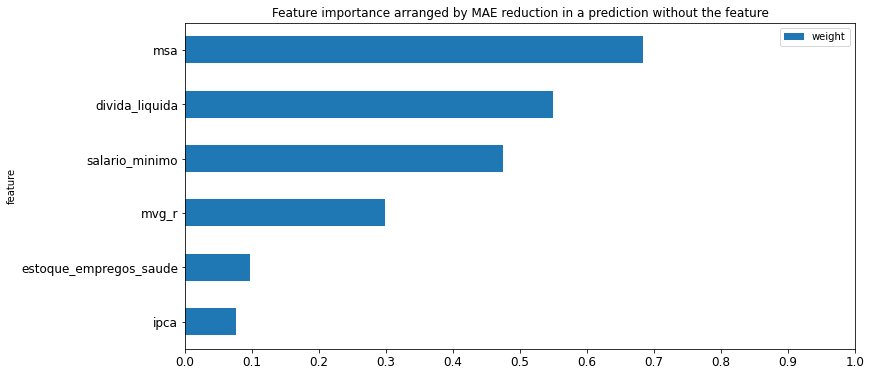

In [15]:
perm = PermutationImportance(neural_network,
                             scoring = 'neg_mean_absolute_error',
                             random_state = 42).fit(X_test, y_test)

# Cria pandas.DataFrame com feature importances
feature_importance = eli5.explain_weights_df(perm,
                                             feature_names = X_test.columns.to_list())

# Ajusta ordem do plot
matplotlib.rcParams['figure.figsize'] = (12, 6)

feature_importance.sort_values('weight', inplace = True)

feature_importance.plot(kind = 'barh',
                        x = 'feature',
                        y = 'weight',
                        xlim = (0, 1),
                        title = 'Feature importance arranged by MAE reduction in a prediction without the feature',
                        xticks = [0, 0.10, 0.2, 0.3, 0.4, 0.5, 
                                  0.6, 0.70, 0.80, 0.9, 1],
                        fontsize = 12)

### Erros do Neural Network

In [16]:
# Predicted values
neural_network.predict(X_test)

array([-0.36202219,  0.16160382, -1.25531936, -0.28035982, -0.94411667,
       -0.06203812,  0.224536  , -0.69093854, -0.60294241,  1.71893192,
       -0.93971557,  0.14765691, -0.66907253, -0.37864946,  0.68219073,
        1.05260646,  1.67177531, -1.1678165 ,  0.87517082,  1.46784415,
       -0.09714964, -0.19320062, -0.62392945,  0.29010474])

In [17]:
# Test values
y_test.values.ravel()

array([-0.21631677,  0.16783986, -1.25902762,  0.15686396, -0.91877461,
       -0.22729267,  0.05808082, -1.41269027, -0.32607581,  2.50570735,
       -1.29195533,  0.25564709, -0.69925653,  0.00320131,  0.10198444,
        1.61665915,  1.177623  , -0.80901557,  1.19957481,  1.7703218 ,
       -0.6114493 , -0.16143725, -1.08341316,  0.00320131])

<AxesSubplot:ylabel='Errors in Standard Deviations Made by Neural Network'>

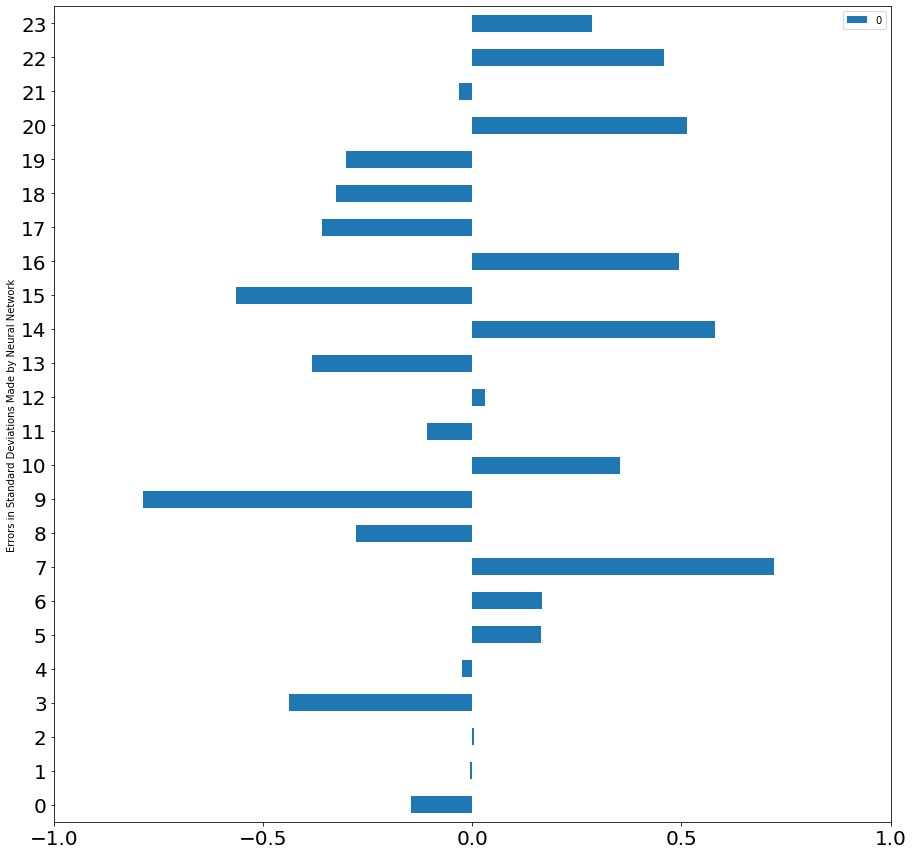

In [18]:
errors = neural_network.predict(X_test) - y_test.values.ravel()

# Plotting prediction error made by neural network
pd.DataFrame(errors).plot(figsize=(15,15),kind = 'barh',
                              xlim = (-1, 1),
                              xlabel = 'Errors in Standard Deviations Made by Neural Network',
                              xticks = [-1, -0.5, 0, 0.5, 1],
                              fontsize = 20)